In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

device = get_free_gpu()

current device cuda:15


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

In [4]:
print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
top_k_file = experiment_folder + "importance/bottleneck_topkinds_seed_{seed}.csv"
makedir(top_k_file)

random_seeds = range(1,4)


27 8 6


## Optimization

In [5]:
def get_model(random_seed):
    set_seed(random_seed)

    config = {
        "n_concepts": 4,
    }

    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)
    model_path = model_path.format(**config, seed = random_seed)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)

    model = models_original.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, device=device)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path, max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


In [ ]:
visualize_top100_weights_per_channel(model.bottleneck)


In [6]:
def plot_metrics(metric_list, percs):
    # Unzip the list of tuples into separate lists
    auc, acc, f1 = zip(*metric_list)
    
    # Plot each metric
    x = range(len(percs))
    plt.plot(x, auc, label='AUC')
    plt.plot(x, acc, label='ACC')
    plt.plot(x, f1, label='F1')
    
    plt.xticks(x, labels=percs)
    
    # Add labels and legend
    plt.xlabel('Percentages')
    plt.ylabel('Metric Value')
    plt.title('Pruning')
    plt.legend()
    
    # Show plot
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


 11%|█         | 11/100 [00:14<01:54,  1.29s/ epoch, Train Loss=0.48274, Val Loss=0.52453, Best Val Loss=0.52344]

Early Stopped


AUC macro 0.914
ACC macro 0.840
 F1 macro 0.848


 20%|██        | 20/100 [00:26<01:46,  1.33s/ epoch, Train Loss=0.48167, Val Loss=0.52632, Best Val Loss=0.52335]

Early Stopped


AUC macro 0.917
ACC macro 0.846
 F1 macro 0.853


 29%|██▉       | 29/100 [00:40<01:38,  1.39s/ epoch, Train Loss=0.47884, Val Loss=0.52718, Best Val Loss=0.52295]

Early Stopped


AUC macro 0.919
ACC macro 0.849
 F1 macro 0.855


 20%|██        | 20/100 [00:29<01:57,  1.47s/ epoch, Train Loss=0.47904, Val Loss=0.52808, Best Val Loss=0.52288]

Early Stopped


AUC macro 0.919
ACC macro 0.849
 F1 macro 0.855


 23%|██▎       | 23/100 [00:33<01:53,  1.47s/ epoch, Train Loss=0.47713, Val Loss=0.52518, Best Val Loss=0.52297]

Early Stopped


AUC macro 0.915
ACC macro 0.843
 F1 macro 0.849


 14%|█▍        | 14/100 [00:21<02:11,  1.53s/ epoch, Train Loss=0.47658, Val Loss=0.52619, Best Val Loss=0.52305]

Early Stopped


AUC macro 0.909
ACC macro 0.833
 F1 macro 0.841


 16%|█▌        | 16/100 [00:23<02:04,  1.48s/ epoch, Train Loss=0.47718, Val Loss=0.52350, Best Val Loss=0.52328]

Early Stopped


AUC macro 0.921
ACC macro 0.853
 F1 macro 0.858


 10%|█         | 10/100 [00:15<02:22,  1.59s/ epoch, Train Loss=0.47686, Val Loss=0.52464, Best Val Loss=0.52280]

Early Stopped


AUC macro 0.912
ACC macro 0.838
 F1 macro 0.845


 22%|██▏       | 22/100 [00:33<01:57,  1.50s/ epoch, Train Loss=0.47517, Val Loss=0.52394, Best Val Loss=0.52339]

Early Stopped


AUC macro 0.920
ACC macro 0.850
 F1 macro 0.856


 13%|█▎        | 13/100 [00:19<02:10,  1.50s/ epoch, Train Loss=0.47392, Val Loss=0.52604, Best Val Loss=0.52320]

Early Stopped


AUC macro 0.915
ACC macro 0.843
 F1 macro 0.850


 17%|█▋        | 17/100 [00:25<02:03,  1.49s/ epoch, Train Loss=0.47464, Val Loss=0.52677, Best Val Loss=0.52375]

Early Stopped


AUC macro 0.913
ACC macro 0.839
 F1 macro 0.846


 25%|██▌       | 25/100 [00:37<01:51,  1.49s/ epoch, Train Loss=0.47348, Val Loss=0.52420, Best Val Loss=0.52363]

Early Stopped


AUC macro 0.918
ACC macro 0.847
 F1 macro 0.853


 19%|█▉        | 19/100 [00:28<02:02,  1.51s/ epoch, Train Loss=0.47267, Val Loss=0.52896, Best Val Loss=0.52355]

Early Stopped


AUC macro 0.919
ACC macro 0.849
 F1 macro 0.855


 22%|██▏       | 22/100 [00:31<01:53,  1.45s/ epoch, Train Loss=0.47257, Val Loss=0.52628, Best Val Loss=0.52351]

Early Stopped


AUC macro 0.915
ACC macro 0.843
 F1 macro 0.850


 21%|██        | 21/100 [00:32<02:01,  1.54s/ epoch, Train Loss=0.47071, Val Loss=0.52592, Best Val Loss=0.52466]

Early Stopped


AUC macro 0.915
ACC macro 0.842
 F1 macro 0.849


 11%|█         | 11/100 [00:17<02:24,  1.62s/ epoch, Train Loss=0.47082, Val Loss=0.52493, Best Val Loss=0.52405]

Early Stopped


AUC macro 0.918
ACC macro 0.848
 F1 macro 0.854


 29%|██▉       | 29/100 [00:42<01:43,  1.46s/ epoch, Train Loss=0.46957, Val Loss=0.52641, Best Val Loss=0.52325]

Early Stopped


AUC macro 0.906
ACC macro 0.833
 F1 macro 0.841


 14%|█▍        | 14/100 [00:21<02:13,  1.55s/ epoch, Train Loss=0.46931, Val Loss=0.52520, Best Val Loss=0.52472]

Early Stopped


AUC macro 0.913
ACC macro 0.841
 F1 macro 0.848


 17%|█▋        | 17/100 [00:25<02:06,  1.52s/ epoch, Train Loss=0.46915, Val Loss=0.52494, Best Val Loss=0.52436]

Early Stopped


AUC macro 0.914
ACC macro 0.842
 F1 macro 0.849


 13%|█▎        | 13/100 [00:20<02:16,  1.57s/ epoch, Train Loss=0.46925, Val Loss=0.52500, Best Val Loss=0.52376]

Early Stopped


AUC macro 0.910
ACC macro 0.837
 F1 macro 0.844


 30%|███       | 30/100 [00:45<01:45,  1.51s/ epoch, Train Loss=0.46837, Val Loss=0.52426, Best Val Loss=0.52265]

Early Stopped


AUC macro 0.915
ACC macro 0.845
 F1 macro 0.851


 11%|█         | 11/100 [00:17<02:20,  1.57s/ epoch, Train Loss=0.47057, Val Loss=0.52370, Best Val Loss=0.52265]

Early Stopped


AUC macro 0.914
ACC macro 0.842
 F1 macro 0.849


 32%|███▏      | 32/100 [00:48<01:43,  1.52s/ epoch, Train Loss=0.46939, Val Loss=0.52295, Best Val Loss=0.52104]

Early Stopped


AUC macro 0.909
ACC macro 0.835
 F1 macro 0.843


 31%|███       | 31/100 [00:46<01:42,  1.49s/ epoch, Train Loss=0.47006, Val Loss=0.52308, Best Val Loss=0.52113]

Early Stopped


AUC macro 0.906
ACC macro 0.829
 F1 macro 0.837


 42%|████▏     | 42/100 [01:02<01:26,  1.49s/ epoch, Train Loss=0.47072, Val Loss=0.52123, Best Val Loss=0.52018]

Early Stopped


AUC macro 0.922
ACC macro 0.856
 F1 macro 0.861


 78%|███████▊  | 78/100 [01:55<00:32,  1.48s/ epoch, Train Loss=0.47284, Val Loss=0.51792, Best Val Loss=0.51783]

Early Stopped


AUC macro 0.912
ACC macro 0.838
 F1 macro 0.846


 55%|█████▌    | 55/100 [01:23<01:08,  1.52s/ epoch, Train Loss=0.47512, Val Loss=0.51541, Best Val Loss=0.51507]

Early Stopped


AUC macro 0.902
ACC macro 0.823
 F1 macro 0.834


 62%|██████▏   | 62/100 [01:32<00:56,  1.49s/ epoch, Train Loss=0.47799, Val Loss=0.51485, Best Val Loss=0.51382]

Early Stopped


AUC macro 0.904
ACC macro 0.821
 F1 macro 0.832


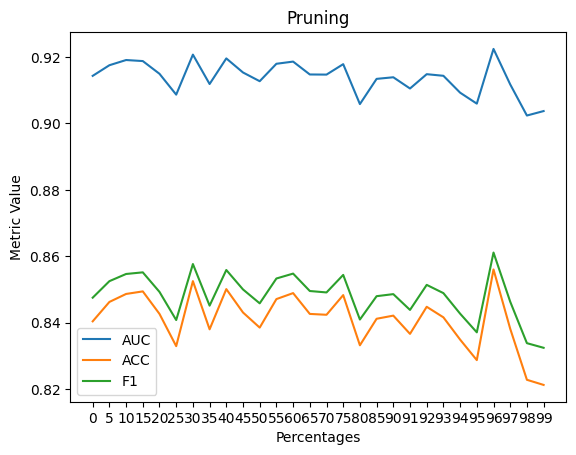

In [7]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    percs = list(range(0, 90, 5)) + list(range(90, 100, 1))
    for perc in percs:
        model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        model.mask_by_weight_magnitude(perc)
        model.clear_ema_gradient()
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)

plot_metrics(metric_list, percs)

In [8]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    metric_list = []
    percs = list(range(0, 90, 5)) + list(range(90, 100, 1))
    for perc in percs:
        model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
        model.mask_by_gradient_magnitude(perc)
        model.clear_ema_gradient()
        metrics = evaluate_classification(model, val_loader)
        metric_list.append(metrics)

plot_metrics(metric_list, percs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


 11%|█         | 11/100 [00:17<02:21,  1.59s/ epoch, Train Loss=0.48274, Val Loss=0.52453, Best Val Loss=0.52344]

Early Stopped


AUC macro 0.914
ACC macro 0.840
 F1 macro 0.848


 20%|██        | 20/100 [00:32<02:08,  1.61s/ epoch, Train Loss=0.48167, Val Loss=0.52632, Best Val Loss=0.52335]

Early Stopped


AUC macro 0.919
ACC macro 0.848
 F1 macro 0.854


 18%|█▊        | 18/100 [00:28<02:08,  1.57s/ epoch, Train Loss=0.48040, Val Loss=0.52446, Best Val Loss=0.52315]

Early Stopped


AUC macro 0.916
ACC macro 0.845
 F1 macro 0.851


 17%|█▋        | 17/100 [00:28<02:21,  1.70s/ epoch, Train Loss=0.48003, Val Loss=0.52617, Best Val Loss=0.52484]

Early Stopped


AUC macro 0.914
ACC macro 0.841
 F1 macro 0.848


 12%|█▏        | 12/100 [00:21<02:35,  1.76s/ epoch, Train Loss=0.47913, Val Loss=0.52606, Best Val Loss=0.52381]

Early Stopped


AUC macro 0.916
ACC macro 0.841
 F1 macro 0.848


 15%|█▌        | 15/100 [00:25<02:26,  1.73s/ epoch, Train Loss=0.48133, Val Loss=0.52354, Best Val Loss=0.52267]

Early Stopped


AUC macro 0.914
ACC macro 0.842
 F1 macro 0.849


  1%|          | 1/100 [00:01<02:43,  1.65s/ epoch, Train Loss=0.48100, Val Loss=0.52379, Best Val Loss=0.52379]

In [ ]:
for random_seed in [1]:
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    # save_model_path = add_subfolder(model.save_model_path, "/importance/")
    # makedir(save_model_path)
    model.opt_lr = 1e-4
    
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=None, max_epochs=100, save_every_n_epochs=1, patience=10)
    model.mask_shrinking_weights()
    model.clear_ema_gradient()
    metrics = evaluate_classification(model, val_loader)
    metric_list.append(metrics)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845


  0%|          | 0/100 [00:00<?, ? epoch/s]

task_type TaskType.CLASSIFICATION False False
output_dim 2 True False
y_true torch.Size([512, 2])
y_pred torch.Size([512, 2])


NotImplementedError: Loss not defined!

In [18]:
total = model.bottleneck.weight.numel()
print(40 / total)

for perc in range(0, 100, 5):
    print(total - total / 100 * perc)

0.01524390243902439
2624.0
2492.8
2361.6
2230.4
2099.2
1968.0
1836.8000000000002
1705.6
1574.4
1443.2
1312.0
1180.8000000000002
1049.6000000000001
918.4000000000001
787.2
656.0000000000002
524.8000000000002
393.5999999999999
262.4000000000001
131.20000000000027


In [6]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    save_path = top_k_file.format(seed=random_seed)
    
    
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
Found 4 Concepts
90th percentile per concept [8.141751  0.8794138 4.321822  7.642881 ]
['Concept 0 len: 79', 'Concept 1 len: 272', 'Concept 2 len: 77', 'Concept 3 len: 71']


100%|██████████| 40/40 [4:08:22<00:00, 372.57s/it, Score=0.91963, acc=0.858, f1=0.863, auc=0.92]   


random_seed 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_2.pt
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
Found 4 Concepts
90th percentile per concept [ 0.28210557 10.270896    6.4929314   2.3336902 ]
['Concept 0 len: 299', 'Concept 1 len: 95', 'Concept 2 len: 105', 'Concept 3 len: 150']


100%|██████████| 40/40 [5:18:27<00:00, 477.68s/it, Score=0.92956, acc=0.842, f1=0.855, auc=0.93]   


random_seed 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_3.pt
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
Found 4 Concepts
90th percentile per concept [1.3721063  9.55452    0.41133872 7.4182534 ]
['Concept 0 len: 239', 'Concept 1 len: 81', 'Concept 2 len: 295', 'Concept 3 len: 72']


100%|██████████| 40/40 [5:24:46<00:00, 487.17s/it, Score=0.92909, acc=0.858, f1=0.865, auc=0.929]  


In [ ]:
random_seed = 1
model = get_model(random_seed)
top_k_inds = get_top_features_per_concept(model.bottleneck)
greedy_results = read_df_from_csv(top_k_file.format(seed=random_seed))

pd.set_option('display.max_rows', 100)

print(len(top_k_inds))
[print(x) for x in top_k_inds]
greedy_results


In [ ]:
plot_selected_weights(model.bottleneck.weight, top_k_inds, greedy_results, 100)

In [8]:
result_df = evaluate_greedy_selection(get_model, get_MIMIC_dataloader, top_k_file, n_experiments=3)
result_df.groupby(["Split", "Mask", "Finetuned"]).mean()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_1.pt
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.914
ACC macro 0.839
 F1 macro 0.846
AUC macro 0.915
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.920
ACC macro 0.858
 F1 macro 0.863
AUC macro 0.916
ACC macro 0.858
 F1 macro 0.863
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_1.pt
AUC macro 0.909
ACC macro 0.837
 F1 macro 0.844
AUC macro 0.909
ACC macro 0.842
 F1 macro 0.848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_2.pt
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
AUC macro 0.923
ACC macro 0.848
 F1 macro 0.856
AUC macro 0.921
ACC macro 0.844
 F1 macro 0.852
AUC macro 0.930
ACC macro 0.842
 F1 macro 0.855
AUC macro 0.926
ACC macro 0.836
 F1 macro 0.850
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_2.pt
AUC macro 0.922
ACC macro 0.852
 F1 macro 0.859
AUC macro 0.917
ACC macro 0.848
 F1 macro 0.855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/n_concepts_4_seed_3.pt
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.920
ACC macro 0.843
 F1 macro 0.850
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.845
AUC macro 0.929
ACC macro 0.858
 F1 macro 0.865
AUC macro 0.923
ACC macro 0.855
 F1 macro 0.862
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/finetuned/n_concepts_4_seed_3.pt
AUC macro 0.924
ACC macro 0.852
 F1 macro 0.859
AUC macro 0.915
ACC macro 0.846
 F1 macro 0.853


Seed       AUC       ACC        F1
Split Mask   Finetuned                                    
test  Empty  False       2.0  0.916475  0.839654  0.847360
      Greedy False       2.0  0.921804  0.849551  0.858044
             True        2.0  0.913676  0.845146  0.852178
val   Empty  False       2.0  0.919034  0.843257  0.850629
      Greedy False       2.0  0.926095  0.852808  0.860713
             True        2.0  0.918211  0.847032  0.853861

In [ ]:
def aggregate_greedy_results(top_k_file):
    metrics = ["AUC", "ACC", "F1"]
    aggregated_metrics_df = read_df_from_csv(top_k_file.format(seed=1))
    aggregated_metrics_df = aggregated_metrics_df[[metrics]]

    seeds = range(2, 4)

    for random_seed in random_seeds:
        greedy_results = read_df_from_csv(top_k_file.format(seed=seed))
        greedy_results = greedy_results[[metrics]]
            
        aggregated_metrics_df += greedy_results

    aggregated_metrics_df /= (len(seeds)+1)

    return aggregated_metrics_df

aggregate_greedy_results(top_k_file)